In [2]:
import sys
sys.path.append('./code')
from importlib import reload

In [3]:
row_colors = ['lightgreen', 'green', 'orange']

columns_to_names = {
    0 : 'Active 1',
    4 : 'Active 2',
    18 : 'Repressive',
}

row_colors_dict = {
'Active 1' : 'lightgreen',
'Active 2' : 'green',
'Repressive' : 'orange',
}

In [4]:
import make_figure4
reload(make_figure4)
from make_figure4 import *
import pickle

goodinds = pickle.load(open('./for_snipping/goodinds', 'rb'))
merged_clustdict = pickle.load(open('./for_snipping/merged_clustdict', 'rb'))
merged_inds_to_subset = pickle.load(open('./for_snipping/merged_inds_to_subset', 'rb'))


cooldict_50kb = pickle.load(open('./for_snipping/cooldict_50kb', 'rb'))
ind_to_gene = pickle.load(open('./for_snipping/ind_to_gene', 'rb'))
all_ind_to_region = pickle.load(open('./for_snipping/all_ind_to_region', 'rb'))

my_treg_comp = pickle.load(open('./for_snipping/my_treg_comp', 'rb'))



1
1


In [5]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [6]:
%load_ext autoreload
%autoreload 2
from hub_pileup import *
from compute_differential_hic_hub import *
from collections import defaultdict
from make_figure4 import *
import itertools
import cooler

our_treg_250kb = cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/Rename_Treg_all_no_chrM.mcool::/resolutions/250000')

our_treg_25kb = cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/Rename_Treg_all_no_chrM.mcool::/resolutions/25000')
our_tcon_25kb = cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/Rename_Tconv_all_no_chrM.mcool::/resolutions/25000')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
HI


In [7]:
from initialize import *
import cooler 

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')

(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)


In [10]:
inter_and_intra_connections_treg = pickle.load(open('./for_snipping/inter_and_intra_connections_treg', 'rb'))
inter_and_intra_connections_tcon = pickle.load(open('./for_snipping/inter_and_intra_connections_tcon', 'rb'))

In [17]:
PARSED_CHROMS_chr = {'chr' + x : y for x, y in chrom_to_start.items()}
PARSED_CHROMS = {x : y for x, y in chrom_to_start.items()}

In [79]:
%autoreload 2
from hub_pileup import pileup_bin_pairs

padding_size = 50
megaloop_pileup_cooldict = {
    'Our_Treg' : our_treg_25kb,
    'Our_Tcon' : our_tcon_25kb,
}

rows_cluster0 = []
for chrom in PARSED_CHROMS:
    s, e = chrom_to_start[chrom], chrom_to_end[chrom]
    df = pd.DataFrame()
    df['ind'] = np.arange(len(all_ind_to_region))
    df['chrom'] = ['chr' + all_ind_to_region[x][0] for x in range(len(all_ind_to_region))]
    df['cluster'] = -1
    df.loc[goodinds, 'cluster'] = merged_clustdict['all']
    df = df.iloc[s:e]
    
    df2 = pd.DataFrame()
    df2['ind'] = goodinds
    df2['chrom'] = ['chr' + all_ind_to_region[x][0] for x in goodinds]
    df2['cluster'] = merged_clustdict['all']
    df2 = df2[df2['cluster'].isin([0])]
    
    all_mat_dict, all_metadata = pileup_bin_pairs(df, df2, megaloop_pileup_cooldict, 
                                                                  PARSED_CHROMS_chr, 
                                                                  inter_and_intra_connections_treg, 
                                                                  inter_and_intra_connections_tcon, 
                                                                  padding_size=padding_size, 
                                                                  fetch_oe=True,
                                                                  resolution_out = 25_000
                        )
        
    for u in all_metadata['ind1'].unique():
        idx = (all_metadata['ind1'] == u) & (all_metadata['cluster2'] == 0)
        submat = all_mat_dict['Our_Treg'][idx]
        inside_filt, outside_filt = make_sideways_filt(submat.shape[1]//2, 5, delta=20)
        inside_filt = np.roll(inside_filt, 5, axis=1)
        inside_filt = np.roll(inside_filt, 5, axis=0)
        outside_filt = np.roll(outside_filt, 5, axis=1)
        outside_filt = np.roll(outside_filt, 5, axis=0)
        v_middle, v_outside = get_inside_outside(submat, inside_filt, outside_filt)
        stat, p, delta, _, _ = test_inside_outside_baseline(v_middle, v_outside, cliplo=-1, cliphigh=10)
        rows_cluster0.append([u, stat, p, delta,])


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 782 10
Done with chr1
chr1 chr15 782 19
Done with chr1
chr1 chr2 782 18
Done with chr1
ch

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 729 10
Done with chr2
chr2 chr15 729 19
Done with chr2
chr2 chr1 729 6
Done with chr2
chr2 chr8 729 17
Done with chr2
chr2 chr9 729 14
Done with chr2
chr2 chr6 729 5
Done with chr2
chr2 chr13 729 3
Done with chr2
chr2 chr4 729 22
Done with chr2
chr2 chr3 729 13
Done with chr2
chr2 chr5 729 16
Done with chr2
chr2 chr19 729 19
Done with chr2
chr2 chr7 729 30
Done with chr2
chr

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr13 0 3
chr14 chr6 0 5
chr14 chr9 0 14
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr13 0 3
chr15 chr6 0 5
chr15 chr9 0 14
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr13 0 3
chr2 chr6 0 5
chr2 chr9 0 14
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr13 0 3
chr1 chr6 0 5
chr1 chr9

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 500 19
Done with chr14
chr14 chr2 500 18
Done with chr14
chr14 chr1 500 6
Done with chr14
chr14 chr8 500 17
Done with chr14
chr14 chr9 500 14
Done with chr14
chr14 chr6 500 5
Done with chr14
chr14 chr13 500 3
Done with chr14
chr14 chr4 500 22
Done with chr14
chr14 chr3 500 13
Done with chr14
chr14 chr5 500 16
Done with chr14
chr14 chr19 500 19
Done with chr14
chr14 chr7 500 30
Done with chr14
chr14 chr18 500 3
Done with chr14
chr14 chr10 500 13
Done with chr14
chr14 chr16 500 7
Done with chr14
chr14 chr11 500 34
Done with chr14
chr14 chr17 500 26
Done with chr14
chr14 chr12 500 9
Done with chr14
chr14 chrX 500 1
Done with chr14
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6


/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 417 10
Done with chr15
chr15 chr2 417 18
Done with chr15
chr15 chr1 417 6
Done with chr15
chr15 chr8 417 17
Done with chr15
chr15 chr9 417 14
Done with chr15
chr15 chr6 417 5
Done with chr15
chr15 chr13 417 3
Done with chr15
chr15 chr4 417 22
Done with chr15
chr15 chr3 417 13
Done with chr15
chr15 chr5 417 16
Done with chr15
chr15 chr19 417 19
Done with chr15
chr15 chr7 417 30
Done with chr15
chr15 chr18 417 3
Done with chr15
chr15 chr10 417 13
Done with chr15
chr15 chr16 417 7
Done with chr15
chr15 chr11 417 34
Done with chr15
chr15 chr17 417 26
Done with chr15
chr15 chr12 417 9
Done with chr15
chr15 chrX 417 1
Done with chr15
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6


/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 19
chr14 chr2 0 18
chr14 chr1 0 6
chr14 chr8 0 17
chr14 chr9 0 14
chr14 chr6 0 5
chr14 chr13 0 3
chr14 chr4 0 22
chr14 chr3 0 13
chr14 chr5 0 16
chr14 chr19 0 19
chr14 chr7 0 30
chr14 chr18 0 3
chr14 chr10 0 13
chr14 chr16 0 7
chr14 chr11 0 34
chr14 chr17 0 26
chr14 chr12 0 9
chr14 chrX 0 1
chr15 chr14 0 10
chr15 chr2 0 18
chr15 chr1 0 6
chr15 chr8 0 17
chr15 chr9 0 14
chr15 chr6 0 5
chr15 chr13 0 3
chr15 chr4 0 22
chr15 chr3 0 13
chr15 chr5 0 16
chr15 chr19 0 19
chr15 chr7 0 30
chr15 chr18 0 3
chr15 chr10 0 13
chr15 chr16 0 7
chr15 chr11 0 34
chr15 chr17 0 26
chr15 chr12 0 9
chr15 chrX 0 1
chr2 chr14 0 10
chr2 chr15 0 19
chr2 chr1 0 6
chr2 chr8 0 17
chr2 chr9 0 14
chr2 chr6 0 5
chr2 chr13 0 3
chr2 chr4 0 22
chr2 chr3 0 13
chr2 chr5 0 16
chr2 chr19 0 19
chr2 chr7 0 30
chr2 chr18 0 3
chr2 chr10 0 13
chr2 chr16 0 7
chr2 chr11 0 34
chr2 chr17 0 26
chr2 chr12 0 9
chr2 chrX 0 1
chr1 chr14 0 10
chr1 chr15 0 19
chr1 chr2 0 18
chr1 chr8 0 17
chr1 chr9 0 14
chr1 chr6 0 5
chr1 chr1

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


In [80]:
%autoreload 2
from hub_pileup import pileup_bin_pairs

padding_size = 50
megaloop_pileup_cooldict = {
    'Our_Treg' : our_treg_25kb,
    'Our_Tcon' : our_tcon_25kb,
}

rows_cluster1 = []
for chrom in PARSED_CHROMS:
    s, e = chrom_to_start[chrom], chrom_to_end[chrom]
    df = pd.DataFrame()
    df['ind'] = np.arange(len(all_ind_to_region))
    df['chrom'] = ['chr' + all_ind_to_region[x][0] for x in range(len(all_ind_to_region))]
    df['cluster'] = -1
    df.loc[goodinds, 'cluster'] = merged_clustdict['all']
    df = df.iloc[s:e]
    
    df2 = pd.DataFrame()
    df2['ind'] = goodinds
    df2['chrom'] = ['chr' + all_ind_to_region[x][0] for x in goodinds]
    df2['cluster'] = merged_clustdict['all']
    df2 = df2[df2['cluster'].isin([4])]
    
    all_mat_dict, all_metadata = pileup_bin_pairs(df, df2, megaloop_pileup_cooldict, 
                                                                  PARSED_CHROMS_chr, 
                                                                  inter_and_intra_connections_treg, 
                                                                  inter_and_intra_connections_tcon, 
                                                                  padding_size=padding_size, 
                                                                  fetch_oe=True,
                                                                  resolution_out = 25_000
                        )
        

    
    for u in all_metadata['ind1'].unique():
        idx = (all_metadata['ind1'] == u) & (all_metadata['cluster2'] == 4)
        submat = all_mat_dict['Our_Treg'][idx]
        inside_filt, outside_filt = make_sideways_filt(submat.shape[1]//2, 5, delta=20)
        inside_filt = np.roll(inside_filt, 5, axis=1)
        inside_filt = np.roll(inside_filt, 5, axis=0)
        outside_filt = np.roll(outside_filt, 5, axis=1)
        outside_filt = np.roll(outside_filt, 5, axis=0)
        v_middle, v_outside = get_inside_outside(submat, inside_filt, outside_filt)
        stat, p, delta, _, _ = test_inside_outside_baseline(v_middle, v_outside, cliplo=-1, cliphigh=10)
        rows_cluster1.append([u, stat, p, delta,])


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 782 8
Done with chr1
chr1 chr15 782 16
Done with chr1
chr1 chr2 782 5
Done with chr1
chr1 chr8 782 8
Done with chr1
chr1 chr9 782 10
Done with 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 729 8
Done with chr2
chr2 chr15 729 16
Done with chr2
chr2 chr1 729 17
Done with chr2
chr2 chr8 729 8
Done with chr2
chr2 chr9 729 10
Done with chr2
chr2 chr6 729 8
Done with chr2
chr2 chr13 729 10
Done with chr2
chr2 chr4 729 10
Done with chr2
chr2 chr3 729 16
Done with chr2
chr2 chr5 729 6
Done with chr2
chr2 chr19 729 3
Done with chr2
chr2 chr7 729 8
Done with chr2
chr2 chr18 729 5
Done with chr2
chr2 chr10 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr13 0 10
chr14 chr6 0 8
chr14 chr9 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr13 0 10
chr15 chr6 0 8
chr15 chr9 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr13 0 10
chr2 chr6 0 8
chr2 chr9 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr13 0 10
chr1 chr6 0 8
chr1 chr9 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 500 16
Done with chr14
chr14 chr2 500 5
Done with chr14
chr14 chr1 500 17
Done with chr14
chr14 chr8 500 8
Done with chr14
chr14 chr9 500 10
Done with chr14
chr14 chr6 500 8
Done with chr14
chr14 chr13 500 10
Done with chr14
chr14 chr4 500 10
Done with chr14
chr14 chr3 500 16
Done with chr14
chr14 chr5 500 6
Done with chr14
chr14 chr19 500 3
Done with chr14
chr14 chr7 500 8
Done with chr14
chr14 chr18 500 5
Done with chr14
chr14 chr10 500 15
Done with chr14
chr14 chr16 500 11
Done with chr14
chr14 chr11 500 8
Done with chr14
chr14 chr17 500 6
Done with chr14
chr14 chr12 500 11
Done with chr14
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 417 8
Done with chr15
chr15 chr2 417 5
Done with chr15
chr15 chr1 417 17
Done with chr15
chr15 chr8 417 8
Done with chr15
chr15 chr9 417 10
Done with chr15
chr15 chr6 417 8
Done with chr15
chr15 chr13 417 10
Done with chr15
chr15 chr4 417 10
Done with chr15
chr15 chr3 417 16
Done with chr15
chr15 chr5 417 6
Done with chr15
chr15 chr19 417 3
Done with chr15
chr15 chr7 417 8
Done with chr15
chr15 chr18 417 5
Done with chr15
chr15 chr10 417 15
Done with chr15
chr15 chr16 417 11
Done with chr15
chr15 chr11 417 8
Done with chr15
chr15 chr17 417 6
Done with chr15
chr15 chr12 417 11
Done with chr15
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 chr4 0 10
chr1 chr3 0 16
chr1 chr5 0 6
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr14 chrX 0 0
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr15 chrX 0 0
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr2 chrX 0 0
chr1 chr14 0 8
chr1 chr15 0 16
chr1 chr2 0 5
chr1 chr8 0 8
chr1 chr9 0 10
chr1 chr6 0 8
chr1 chr13 0 10
chr1 c

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:55: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:56: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:104: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(v_middle.clip(cliplo, cliphigh)) - np.nanmean(v_outside.clip(cliplo, cliphigh))


In [232]:
data0 = pd.DataFrame(rows_cluster0, columns = ['ind', 'stat', 'p', 'delta']).set_index('ind')
data1 = pd.DataFrame(rows_cluster1, columns = ['ind', 'stat', 'p', 'delta']).set_index('ind')

df = pd.DataFrame()
df['ind'] = np.arange(len(all_ind_to_region))
df['chrom'] = ['chr' + all_ind_to_region[x][0] for x in range(len(all_ind_to_region))]
df['cluster'] = -1
df.loc[goodinds, 'cluster'] = merged_clustdict['all']

In [234]:
count_idx0, count_idx4, count_recover0, count_recover4, count_others

(0, 0, 0, 0, 452)

In [236]:
idx0

False

In [241]:
count_idx0, count_idx4, count_recover0, count_recover4

(93, 140, 0, 0)

In [245]:
(count_idx0 + count_idx4 + count_recover0 + count_recover4) / SE_count.sum()

1.579646017699115

In [250]:
(count_idx0 + count_idx4)/SE_count.sum()

0.5154867256637168

In [272]:
idx = (idx0 | idx4 | recover0 | recover4)

(SE_count[idx]>0).mean(), idx.sum(), (SE_count>0).mean()

(0.26067211625794734, 1101, 0.03660849772382398)

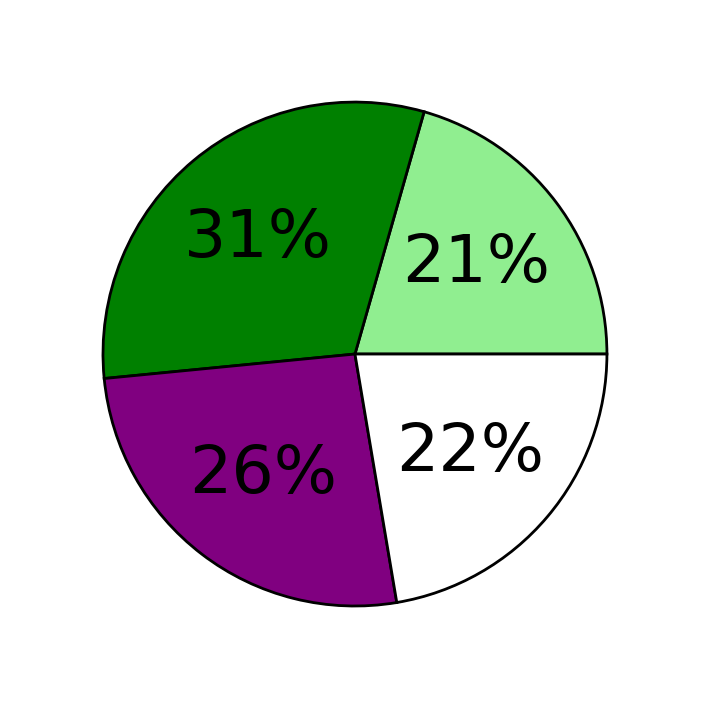

In [281]:
co = .03
idx0 = (df['cluster']==0) 
idx4 = (df['cluster']==4)
recover0 = ((data0['delta'] > co) & (data0['p'] < 1e-20))
recover4 = ((data1['delta'] > co) & (data1['p'] < 1e-20))

count_idx0 = SE_count[idx0].sum()
count_idx4 = SE_count[idx4].sum()
count_recover0 = SE_count[(recover0 | recover4) & (~(idx0 | idx4)) ].sum()
# count_recover4 = SE_count[(recover4 | recover0) & (~(idx0 | idx4 | recover0))].sum()
count_others = SE_count[~(idx0 | idx4 | recover0 | recover4)].sum()

fig, axs = init_subplots_exact(1, 1, fgsz=(40*mm, 40*mm), dpi = 200)
plt.pie([count_idx0, count_idx4, count_recover0, count_others],
       colors=['lightgreen', 'green', 'purple', 'white'], autopct='%1.0f%%', 
       wedgeprops={"edgecolor":"k", 'linewidth': .5, }
       )
fig.savefig('./plots/FINAL_CHIP_PLOTS/pie.pdf')

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/

Text(0.5, 1.0, 'Megaloops')

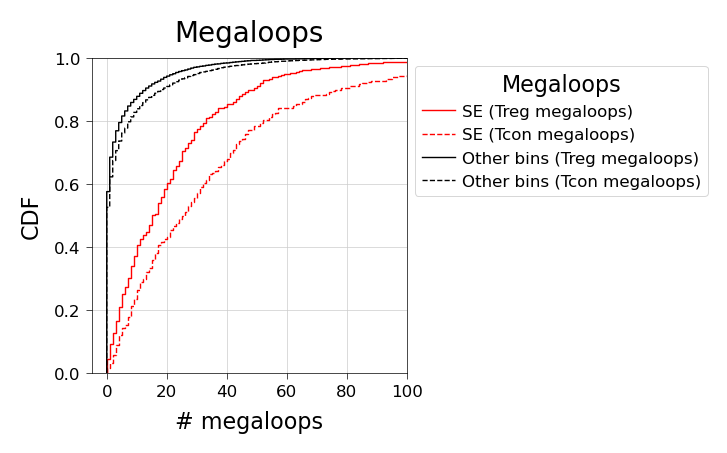

In [342]:
fig, axs = init_subplots_exact(1, 1, fgsz = (40*mm, 40*mm), dpi = 100, xspace=1.4, as_list=True)
plt.sca(axs[0])
sns.ecdfplot(inter_and_intra_connections_treg.sum(axis=1)[(SE_count>0)], color='red', label='SE (Treg megaloops)')
sns.ecdfplot(inter_and_intra_connections_tcon.sum(axis=1)[(SE_count>0)], color='red', label='SE (Tcon megaloops)', linestyle='--')
sns.ecdfplot(inter_and_intra_connections_treg.sum(axis=1)[(SE_count==0)], color='black', label='Other bins (Treg megaloops)')
sns.ecdfplot(inter_and_intra_connections_tcon.sum(axis=1)[(SE_count==0)], color='black', label='Other bins (Tcon megaloops)', linestyle='--')
plt.legend(bbox_to_anchor=(1, 1), handlelength=2, loc='upper left', title='Megaloops', title_fontsize=8)
plt.xlim([-5, 100])
plt.xlabel("# megaloops")
plt.ylabel("CDF")
plt.title("Megaloops")

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/

Text(0.5, 1.0, 'Megaloops (bins not in hub)')

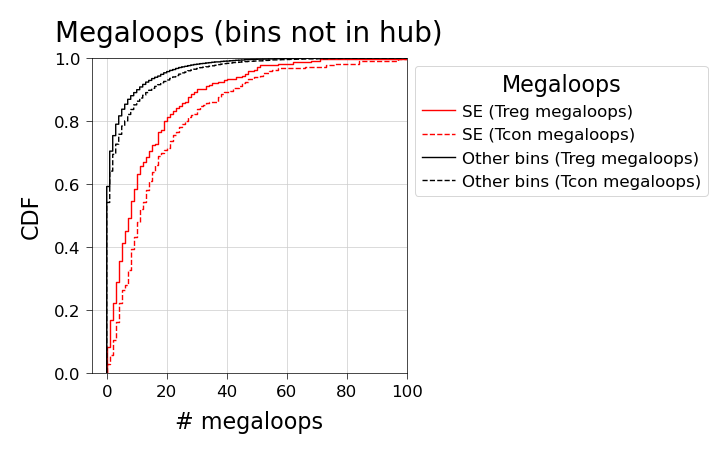

In [316]:
fig, axs = init_subplots_exact(1, 1, fgsz = (40*mm, 40*mm), dpi = 100, xspace=1.4, as_list=True)
plt.sca(axs[0])
sns.ecdfplot(inter_and_intra_connections_treg.sum(axis=1)[(SE_count>0) & (~df['cluster'].isin([0, 4]))], color='red', label='SE (Treg megaloops)')
sns.ecdfplot(inter_and_intra_connections_tcon.sum(axis=1)[(SE_count>0) & (~df['cluster'].isin([0, 4]))], color='red', label='SE (Tcon megaloops)', linestyle='--')
sns.ecdfplot(inter_and_intra_connections_treg.sum(axis=1)[(SE_count==0) & (~df['cluster'].isin([0, 4]))], color='black', label='Other bins (Treg megaloops)')
sns.ecdfplot(inter_and_intra_connections_tcon.sum(axis=1)[(SE_count==0) & (~df['cluster'].isin([0, 4]))], color='black', label='Other bins (Tcon megaloops)', linestyle='--')
plt.legend(bbox_to_anchor=(1, 1), handlelength=2, loc='upper left', title='Megaloops', title_fontsize=8)
plt.xlim([-5, 100])
plt.xlabel("# megaloops")
plt.ylabel("CDF")
plt.title("Megaloops (bins not in hub)")

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/

Text(0.5, 1.0, 'Megaloops (bins in hubs)')

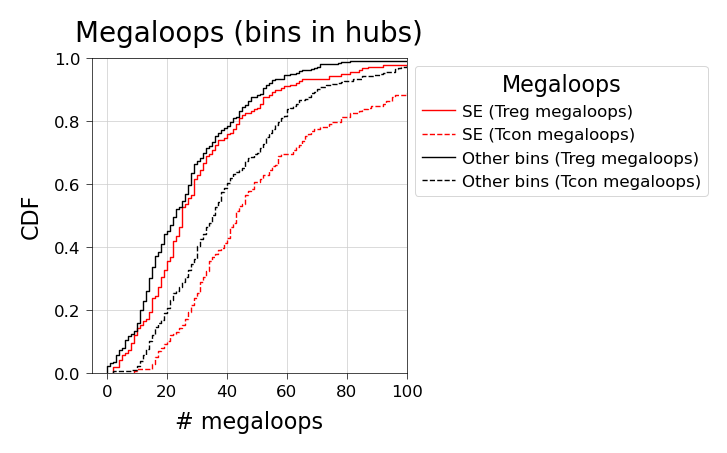

In [315]:
fig, axs = init_subplots_exact(1, 1, fgsz = (40*mm, 40*mm), dpi = 100, xspace=1.4, as_list=True)
plt.sca(axs[0])
sns.ecdfplot(inter_and_intra_connections_treg.sum(axis=1)[(SE_count>0) & (df['cluster'].isin([0, 4]))], color='red', label='SE (Treg megaloops)')
sns.ecdfplot(inter_and_intra_connections_tcon.sum(axis=1)[(SE_count>0) & (df['cluster'].isin([0, 4]))], color='red', label='SE (Tcon megaloops)', linestyle='--')
sns.ecdfplot(inter_and_intra_connections_treg.sum(axis=1)[(SE_count==0) & (df['cluster'].isin([0, 4]))], color='black', label='Other bins (Treg megaloops)')
sns.ecdfplot(inter_and_intra_connections_tcon.sum(axis=1)[(SE_count==0) & (df['cluster'].isin([0, 4]))], color='black', label='Other bins (Tcon megaloops)', linestyle='--')
plt.legend(bbox_to_anchor=(1, 1), handlelength=2, loc='upper left', title='Megaloops', title_fontsize=8)
plt.xlim([-5, 100])
plt.xlabel("# megaloops")
plt.ylabel("CDF")
plt.title("Megaloops (bins in hubs)")




/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/

Text(0.5, 1.0, 'A Compartment in hubs')

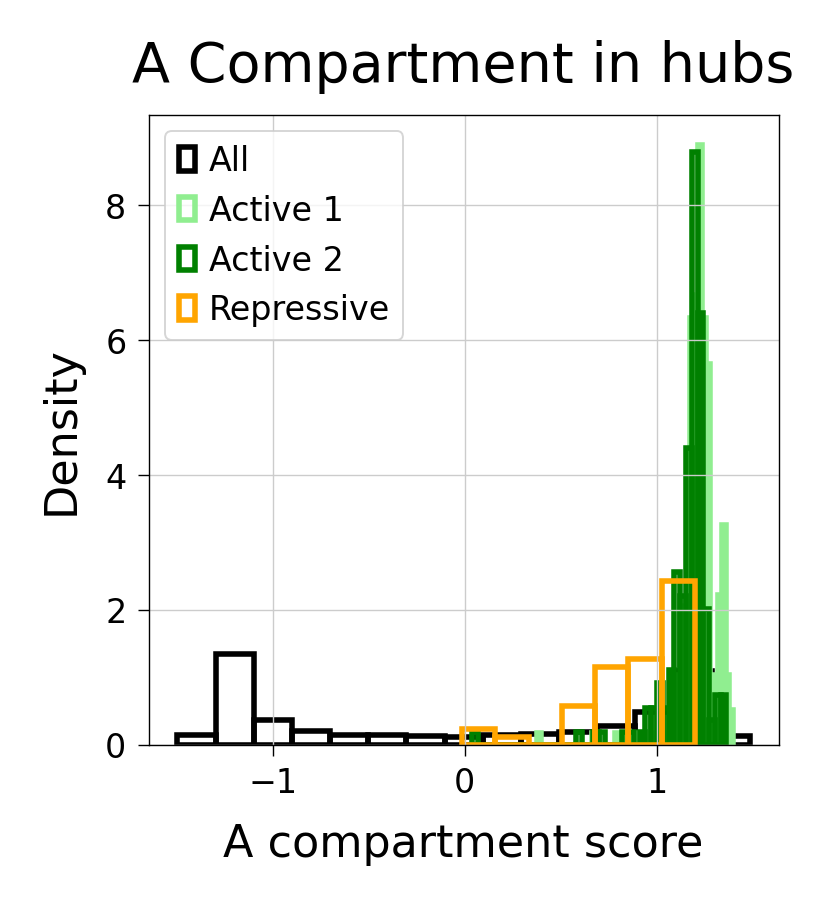

In [340]:
fig, axs = init_subplots_exact(1, 1, fgsz=(40*mm, 40*mm), dpi = 200)
sns.histplot(my_treg_comp[:], color='black', stat='density', fill=False, linewidth=1, label='All')
sns.histplot(my_treg_comp[df['cluster']==0], color='lightgreen', stat='density', fill=False, linewidth=1, label='Active 1')
sns.histplot(my_treg_comp[df['cluster']==4], color='green', stat='density', fill=False, linewidth=1, label='Active 2')
sns.histplot(my_treg_comp[df['cluster']==18], color='orange', stat='density', fill=False, linewidth=1, label='Repressive')
plt.xlabel("A compartment score")
plt.legend()
plt.title("A Compartment in hubs")

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/

Text(0.5, 0, 'A compartment score')

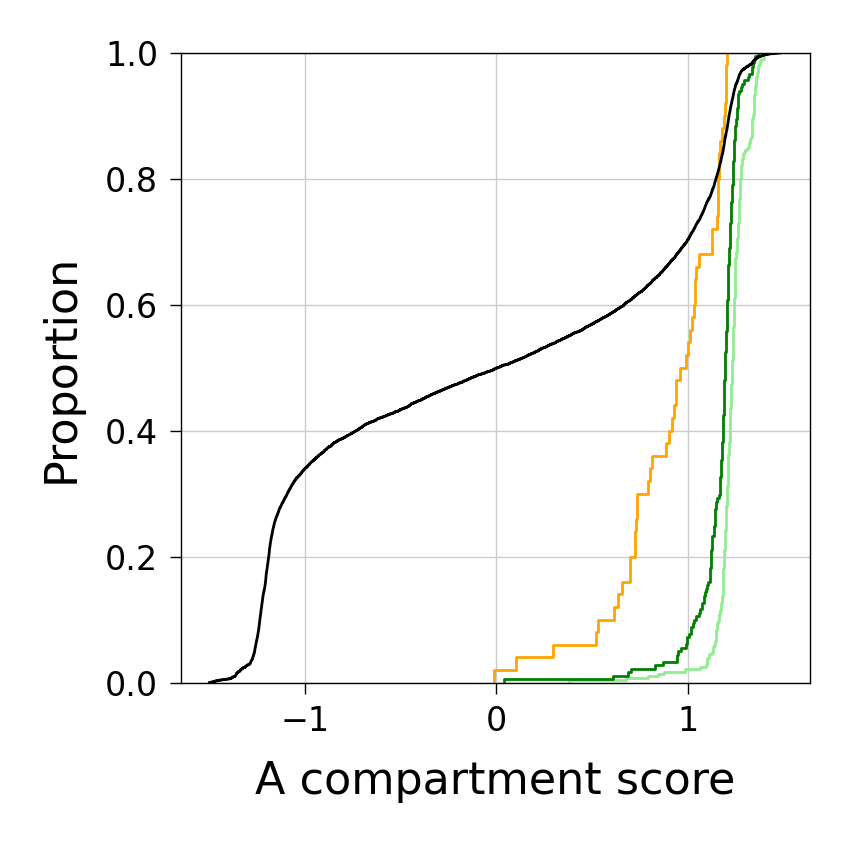

In [327]:
fig, axs = init_subplots_exact(1, 1, fgsz=(40*mm, 40*mm), dpi = 200)
sns.ecdfplot(my_treg_comp[df['cluster']==0], color='lightgreen')
sns.ecdfplot(my_treg_comp[df['cluster']==4], color='green')
sns.ecdfplot(my_treg_comp[df['cluster']==18], color='orange')
sns.ecdfplot(my_treg_comp[:], color='black', label='All')

plt.xlabel("A compartment score")

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/

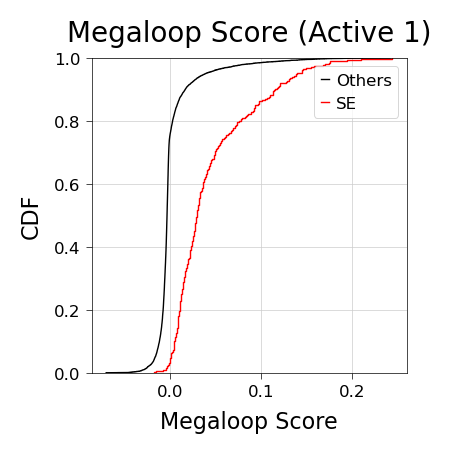

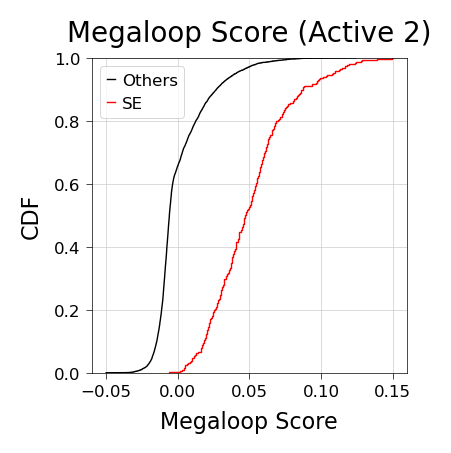

In [356]:
fig, axs = init_subplots_exact(1, 1, fgsz = (40*mm, 40*mm), dpi = 100, xspace=1.4, as_list=True)

sns.ecdfplot(data0[SE_count==0]['delta'], color='black', label='Others')
sns.ecdfplot(data0[SE_count>0]['delta'], color='red', label='SE')
plt.xlabel("Megaloop Score")
plt.ylabel("CDF")
plt.title("Megaloop Score (Active 1)")
plt.legend()



fig, axs = init_subplots_exact(1, 1, fgsz = (40*mm, 40*mm), dpi = 100, xspace=1.4, as_list=True)

sns.ecdfplot(data1[SE_count==0]['delta'], color='black', label='Others')
sns.ecdfplot(data1[SE_count>0]['delta'], color='red', label='SE')
plt.xlabel("Megaloop Score")
plt.ylabel("CDF")
plt.title("Megaloop Score (Active 2)")
plt.legend()


In [89]:
SEs = pbt.BedTool('superenhancers/common_SE_liftover.bed')
SE_treg = pbt.BedTool('superenhancers/Treg_SE_liftover.bed')
SE_tn = pbt.BedTool('superenhancers/Tn_SE_liftover.bed')
SEs = SEs.cat(SE_treg).cat(SE_tn)
SE_count = get_col(pbt.BedTool(add_chr_to_bedtool(all_ind_to_region)).intersect(SEs, c=True), -1).astype(int)


In [137]:
idx_cluster0 = ((data0['delta'] > .05) & (data0['p'] < 1e-20))
idx_cluster1 = ((data1['delta'] > .05) & (data1['p'] < 1e-20))


In [213]:
idx = np.where(((data0['p'] > 1e-4) & (data1['p'] > 1e-4)) & (SE_count > 0))

In [164]:
for co in [.03, .035, .04, .05]:
    print("___")
    ses = np.sum(SE_count[)
    idx = ((df['cluster']==0) 
           | (df['cluster']==4)
           | ((data0['delta'] > co) & (data0['p'] < 1e-20))
           | ((data1['delta'] > co) & (data1['p'] < 1e-20))
          )
    print(np.sum(idx))
    print(ses/np.sum(idx))
    print(np.sum(SE_count[(df['cluster']==0) 
           | (df['cluster']==4)
           | ((data0['delta'] > co) & (data0['p'] < 1e-20))
           | ((data1['delta'] > co) & (data1['p'] < 1e-20))
           ]) / np.sum(SE_count)
         )

___
0.7765486725663717
1101
0.3188010899182561
___
0.7411504424778761
985
0.3401015228426396
___
0.7013274336283186
882
0.35941043083900226
___
0.6438053097345132
709
0.4104372355430183


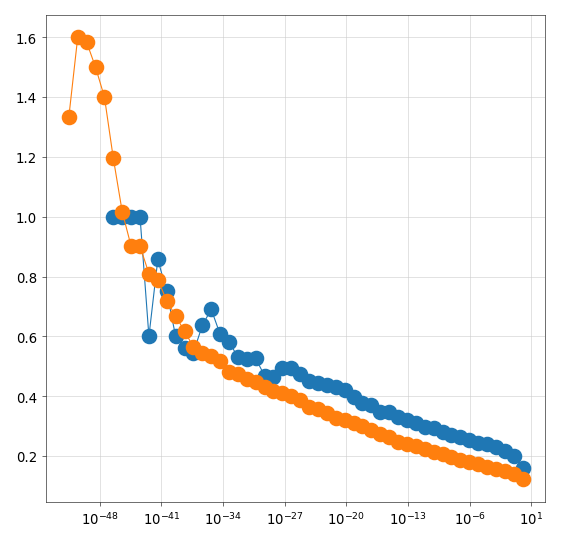

In [122]:
xs = np.geomspace(1e-100, 1, 100)
ys = []
for pco in xs:
    y = np.nanmean(SE_count[((data0['delta'] > 0) & (data0['p'] < pco))])
    ys.append(y)
plt.plot(xs, ys, marker='o')


xs = np.geomspace(1e-100, 1, 100)
ys = []
for pco in xs:
    y = np.nanmean(SE_count[((data1['delta'] > 0) & (data1['p'] < pco))])
    ys.append(y)
plt.plot(xs, ys, marker='o')

plt.xscale('log')

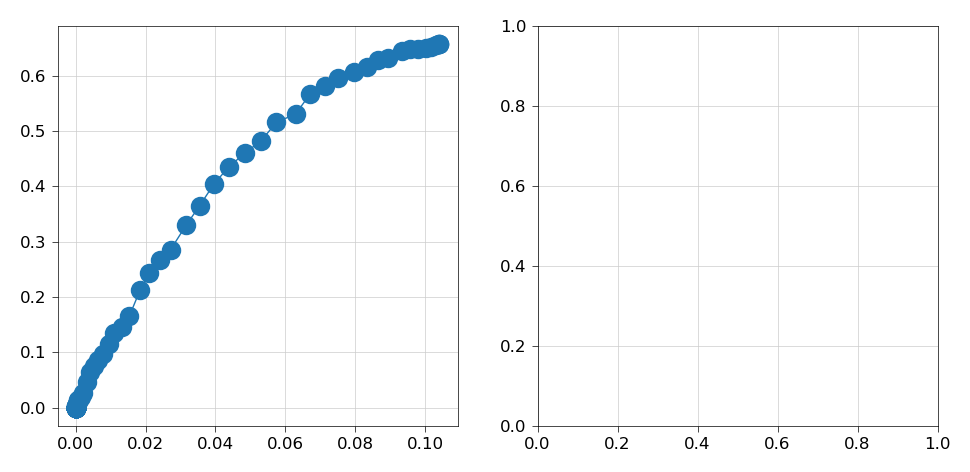

In [136]:
fig, axs = init_subplots_exact(2, 1, dpi = 100, fgsz=(2, 2))
plt.sca(axs[0])
xs = np.geomspace(1e-100, 1, 100)
ys = []
ns = []
for pco in xs:
    idx = ((data0['delta'] > 0.02) & (data0['p'] < pco))
    y = np.nansum(SE_count[idx]) / np.nansum(SE_count)
    ys.append(y)
    ns.append(np.nanmean(idx))
plt.plot(ns, ys, marker='o')


# xs = np.geomspace(1e-100, 1, 100)
# ys = []
# for pco in xs:
#     y = np.nansum(SE_count[((data1['delta'] > 0.05) & (data1['p'] < pco))]) / np.nansum(SE_count)
#     ys.append(y)
# plt.plot(xs, ys, marker='o')
# plt.xscale('log')


# plt.sca(axs[1])
# xs = np.geomspace(1e-100, 1, 100)
# ys = []
# for pco in xs:
#     y = np.nansum((data0['delta'] > 0.05) & (data0['p'] < pco))
#     ys.append(y)
# plt.plot(xs, ys, marker='o')


# xs = np.geomspace(1e-100, 1, 100)
# ys = []
# for pco in xs:
#     ys.append(y)
# plt.plot(xs, ys, marker='o')
# plt.xscale('log')

In [ ]:
sig_inds = 
np.sum(SE_count[
       ]) / np.sum(SE_count)

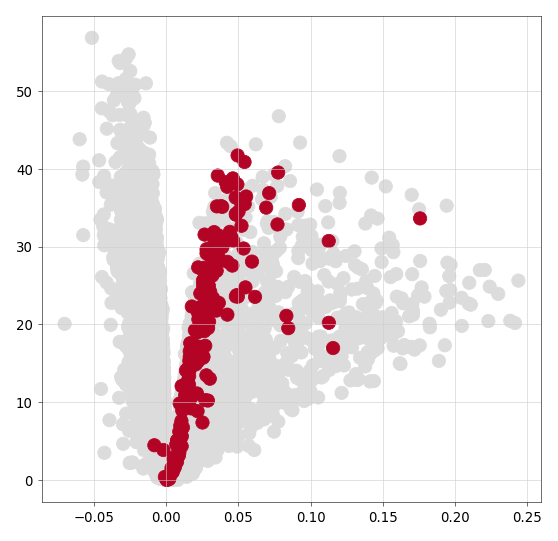

In [110]:
c = df['cluster'] == 4

idx = df['cluster'] != 4
plt.scatter(data0['delta'][idx],
            -np.log10(data0['p'])[idx],
            c = c[idx],
            cmap='coolwarm',
            vmin = -1, vmax = 1
           )

idx = df['cluster'] == 4
plt.scatter(data0['delta'][idx],
            -np.log10(data0['p'])[idx],
            c = c[idx],
            cmap='coolwarm',
            vmin = -1, vmax = 1
           )

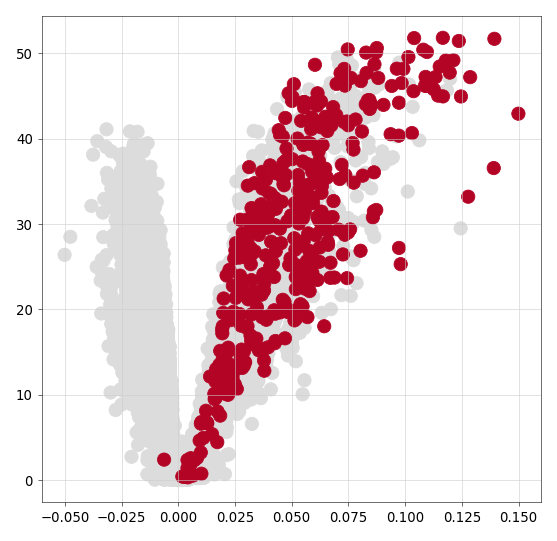

In [114]:
c = SE_count > 0

idx = SE_count == 0
plt.scatter(data1['delta'][idx],
            -np.log10(data1['p'])[idx],
            c = c[idx],
            cmap='coolwarm',
            vmin = -1, vmax = 1
           )

idx = SE_count > 0
plt.scatter(data1['delta'][idx],
            -np.log10(data1['p'])[idx],
            c = c[idx],
            cmap='coolwarm',
            vmin = -1, vmax = 1
           )

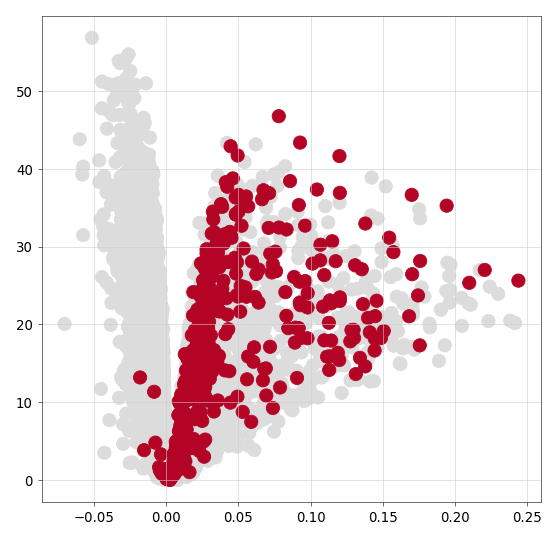

In [115]:
c = SE_count > 0

idx = SE_count == 0
plt.scatter(data0['delta'][idx],
            -np.log10(data0['p'])[idx],
            c = c[idx],
            cmap='coolwarm',
            vmin = -1, vmax = 1
           )

idx = SE_count > 0
plt.scatter(data0['delta'][idx],
            -np.log10(data0['p'])[idx],
            c = c[idx],
            cmap='coolwarm',
            vmin = -1, vmax = 1
           )

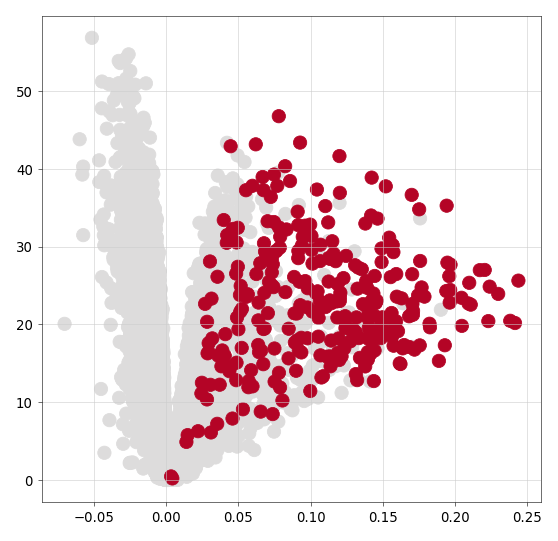

In [145]:
c = df['cluster'] == 0

idx = c == 0
plt.scatter(data0['delta'][idx],
            -np.log10(data0['p'])[idx],
            c = c[idx],
            cmap='coolwarm',
            vmin = -1, vmax = 1
           )

idx = c > 0
plt.scatter(data0['delta'][idx],
            -np.log10(data0['p'])[idx],
            c = c[idx],
            cmap='coolwarm',
            vmin = -1, vmax = 1
           )

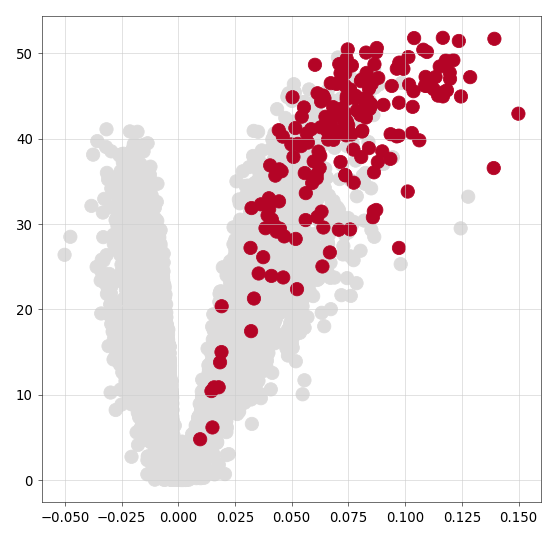

In [147]:
c = df['cluster'] == 4

idx = c == 0
plt.scatter(data1['delta'][idx],
            -np.log10(data1['p'])[idx],
            c = c[idx],
            cmap='coolwarm',
            vmin = -1, vmax = 1
           )

idx = c > 0
plt.scatter(data1['delta'][idx],
            -np.log10(data1['p'])[idx],
            c = c[idx],
            cmap='coolwarm',
            vmin = -1, vmax = 1
           )

Text(0, 0.5, 'MS: Active 1')

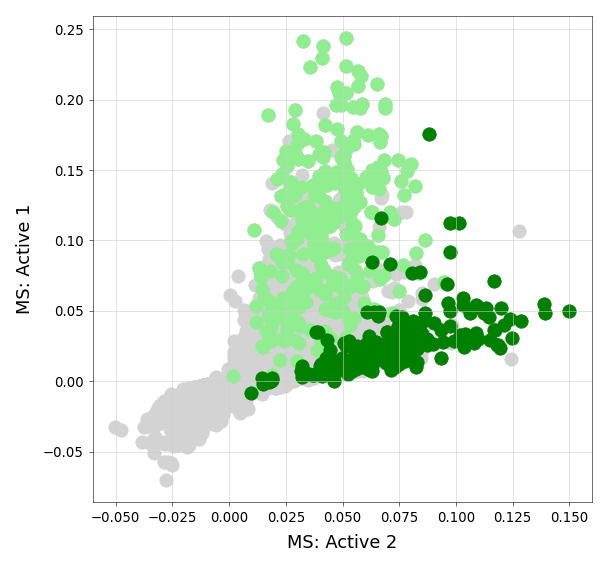

In [156]:
plt.scatter(data1['delta'], data0['delta'], color='lightgray')

idx = df['cluster'] == 0
plt.scatter(data1['delta'][idx],
            data0['delta'][idx], color='lightgreen')

idx = df['cluster'] == 4
plt.scatter(data1['delta'][idx],
            data0['delta'][idx], color='green')
plt.xlabel("MS: Active 2")
plt.ylabel("MS: Active 1")

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


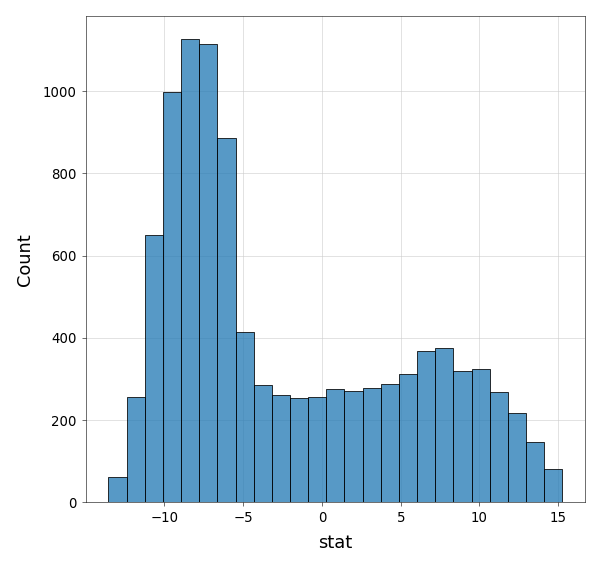

In [56]:
sns.histplot(data['stat'])
plt.gca().set_axisbelow(True)

In [52]:
data['is_megaloop'] = data['stat'] > 5

In [54]:
data['is_megaloop'].mean()

0.22647951441578149

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/

<Axes: xlabel='stat', ylabel='Density'>

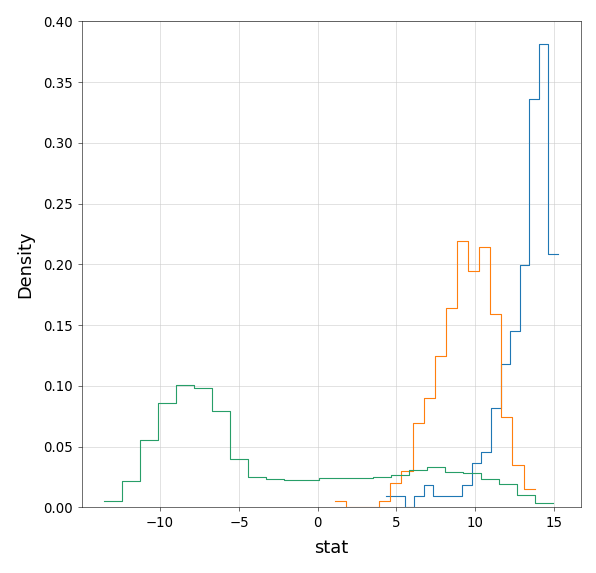

In [39]:
sns.histplot(data['stat'][df['cluster'].isin([4])], stat='density', 
             element='step', fill=False)

sns.histplot(data['stat'][df['cluster'].isin([0])], stat='density', 
             element='step', fill=False)

sns.histplot(data['stat'][~df['cluster'].isin([4])], stat='density', 
             element='step', fill=False)

In [48]:
from compute_differential_hic_hub import make_sideways_filt

plt.matshow(np.nanmean(submat, axis=0)*inside_filt)
plt.matshow(np.nanmean(submat, axis=0)*outside_filt)


In [192]:
data1.loc[85]

stat     1.029673e+01
p        7.289705e-25
delta    3.751348e-02
Name: 85, dtype: float64

In [207]:
idx = (all_metadata['ind1'] == 85) & (all_metadata['cluster2'] == 4)
submat = all_mat_dict['Our_Treg'][idx]

inside_filt, outside_filt = make_sideways_filt(submat.shape[1]//2, 5, delta=20)
inside_filt = np.roll(inside_filt, 5, axis=1)
inside_filt = np.roll(inside_filt, 5, axis=0)
outside_filt = np.roll(outside_filt, 5, axis=1)
outside_filt = np.roll(outside_filt, 5, axis=0)
v_middle, v_outside = get_inside_outside(submat, inside_filt, outside_filt)
stat, p, delta, _, _ = test_inside_outside_baseline(v_middle, v_outside, cliplo=-1, cliphigh=10)


In [209]:
data0.loc[85]

stat     2.398607
p        0.016458
delta    0.005225
Name: 85, dtype: float64

In [208]:
p

7.289705316441302e-25

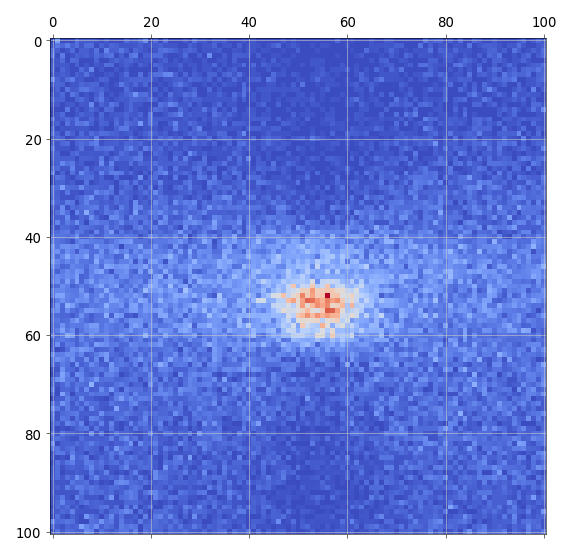

In [199]:
m = np.nanmean(submat, axis=0)
plt.matshow(m)

### Plot one site

In [194]:
s, e = chrom_to_start['1'], chrom_to_end['1']
df = pd.DataFrame()
df['ind'] = np.arange(len(all_ind_to_region))
df['chrom'] = ['chr' + all_ind_to_region[x][0] for x in range(len(all_ind_to_region))]
df['cluster'] = -1
df.loc[goodinds, 'cluster'] = merged_clustdict['all']
df = df.iloc[s:e]

df2 = pd.DataFrame()
df2['ind'] = goodinds
df2['chrom'] = ['chr' + all_ind_to_region[x][0] for x in goodinds]
df2['cluster'] = merged_clustdict['all']
df2 = df2[df2['cluster'].isin([4])]

all_mat_dict, all_metadata = pileup_bin_pairs(df, df2, megaloop_pileup_cooldict, 
                                                              PARSED_CHROMS_chr, 
                                                              inter_and_intra_connections_treg, 
                                                              inter_and_intra_connections_tcon, 
                                                              padding_size=padding_size, 
                                                              fetch_oe=True,
                                                              resolution_out = 25_000
                    )
    


chr14 chr15 0 16
chr14 chr2 0 5
chr14 chr1 0 17
chr14 chr8 0 8
chr14 chr9 0 10
chr14 chr6 0 8
chr14 chr13 0 10
chr14 chr4 0 10
chr14 chr3 0 16
chr14 chr5 0 6
chr14 chr19 0 3
chr14 chr7 0 8
chr14 chr18 0 5
chr14 chr10 0 15
chr14 chr16 0 11
chr14 chr11 0 8
chr14 chr17 0 6
chr14 chr12 0 11
chr15 chr14 0 8
chr15 chr2 0 5
chr15 chr1 0 17
chr15 chr8 0 8
chr15 chr9 0 10
chr15 chr6 0 8
chr15 chr13 0 10
chr15 chr4 0 10
chr15 chr3 0 16
chr15 chr5 0 6
chr15 chr19 0 3
chr15 chr7 0 8
chr15 chr18 0 5
chr15 chr10 0 15
chr15 chr16 0 11
chr15 chr11 0 8
chr15 chr17 0 6
chr15 chr12 0 11
chr2 chr14 0 8
chr2 chr15 0 16
chr2 chr1 0 17
chr2 chr8 0 8
chr2 chr9 0 10
chr2 chr6 0 8
chr2 chr13 0 10
chr2 chr4 0 10
chr2 chr3 0 16
chr2 chr5 0 6
chr2 chr19 0 3
chr2 chr7 0 8
chr2 chr18 0 5
chr2 chr10 0 15
chr2 chr16 0 11
chr2 chr11 0 8
chr2 chr17 0 6
chr2 chr12 0 11
chr1 chr14 782 8
Done with chr1
chr1 chr15 782 16
Done with chr1
chr1 chr2 782 5
Done with chr1
chr1 chr8 782 8
Done with chr1
chr1 chr9 782 10
Done with 